# Decision Tree Regression

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

# Step 1: Read the dataset

In [3]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.head()

,RND,ADMIN,MKT,STATE,PROFIT
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


# Step 2: Perform basic data quality checks

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RND     50 non-null     float64
 1   ADMIN   50 non-null     float64
 2   MKT     50 non-null     float64
 3   STATE   50 non-null     object 
 4   PROFIT  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [5]:
df.isna().sum()

RND       0
ADMIN     0
MKT       0
STATE     0
PROFIT    0
dtype: int64

In [6]:
df.duplicated().sum()


0

# Step 3: Seperate X and Y

In [8]:
X = df.drop(columns=['PROFIT'])
Y = df[['PROFIT']]

In [9]:

X.head()

,RND,ADMIN,MKT,STATE
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


In [10]:
Y.head()

,PROFIT
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


# Step 4: Create preprocessing Pipeline for X

In [11]:
# cat and con features seperate
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [12]:
cat

['STATE']

In [13]:
con

['RND', 'ADMIN', 'MKT']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


In [15]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [16]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [17]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [18]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0


# Step 5: Apply train test split

In [19]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y, test_size=0.2, random_state=21)

In [20]:
xtrain.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
30,-0.258074,-0.205629,-0.990357,0.0,1.0,0.0
21,0.102724,1.169186,0.732788,0.0,0.0,1.0
19,0.279442,1.159837,-1.743127,0.0,0.0,1.0
11,0.593085,-1.065540,0.319834,1.0,0.0,0.0
22,0.006007,0.051850,0.762376,0.0,1.0,0.0


In [21]:
ytrain.head()

,PROFIT
30,99937.59
21,111313.02
19,122776.86
11,144259.40
22,110352.25


In [22]:
xtest.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
7,1.245057,0.871980,0.932186,0.0,1.0,0.0
44,-1.134305,1.206419,-1.509074,1.0,0.0,0.0
43,-1.281134,0.217682,-1.449605,0.0,0.0,1.0
25,-0.199312,0.656489,-0.603517,1.0,0.0,0.0
14,1.017181,1.269199,0.375742,0.0,1.0,0.0


In [23]:
ytest.head()

,PROFIT
7,155752.60
44,65200.33
43,69758.98
25,107404.34
14,132602.65


In [24]:
xtrain.shape

(40, 6)

In [25]:
xtest.shape

(10, 6)

# Step 6: Build the base model

In [26]:
from sklearn.tree import DecisionTreeRegressor
model1 = DecisionTreeRegressor(max_depth=1,
                               min_samples_split=5,
                               min_samples_leaf=5,
                               criterion='absolute_error')
model1.fit(xtrain, ytrain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=1,
                      min_samples_leaf=5, min_samples_split=5)

In [27]:
model1.score(xtrain, ytrain)

0.6019636534994364

In [28]:
model1.score(xtest, ytest)

0.5746278420052591

# Step 7: Hyperparameter tuning

In [29]:
params = {'max_depth':[2, 3, 4, 5, 6, 7],
          'min_samples_split':[2, 3, 4, 5, 6, 7],
          'min_samples_leaf':[2, 3, 4, 5, 6, 7],
          'criterion':['absolute_error', 'squared_error']}

In [30]:
from sklearn.model_selection import GridSearchCV
dtr = DecisionTreeRegressor()
gscv = GridSearchCV(dtr, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             scoring='neg_mean_absolute_error')

In [31]:
gscv.best_params_

{'criterion': 'absolute_error',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 4}

In [32]:
gscv.best_score_

-9559.963

In [35]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=2, min_samples_split=4)

# Steps 8: Evaluate the model

In [36]:
best_dtr.score(xtrain, ytrain)

0.9874530390958045

In [37]:
best_dtr.score(xtest, ytest)

0.9479239727913178

In [38]:
ypred_train = best_dtr.predict(xtrain)
ypred_test = best_dtr.predict(xtest)

In [39]:


ypred_train[0:5]

array([ 98682.715, 111313.02 , 111313.02 , 144259.4  , 105733.54 ])

In [40]:
ytrain.head()

,PROFIT
30,99937.59
21,111313.02
19,122776.86
11,144259.40
22,110352.25


In [42]:
ypred_test[0:5]

array([156991.12 ,  77798.83 ,  77798.83 , 105733.54 , 150985.865])

In [43]:
ytest.head()

,PROFIT
7,155752.60
44,65200.33
43,69758.98
25,107404.34
14,132602.65


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluate_model(model, x, y):
    ypred = model.predict(x)
    mse = mean_squared_error(y, ypred)
    rmse = mse**(1/2)
    mae = mean_absolute_error(y, ypred)
    r2 = r2_score(y, ypred)
    print(f'Mean Squared Error : {mse:.2f}')
    print(f'Root Mean Squared Error : {rmse:.2f}')
    print(f'Mean Absolute Error : {mae:.2f}')
    print(f'R2 Score : {r2:.4f}')

In [45]:
evaluate_model(best_dtr, xtrain, ytrain)

Mean Squared Error : 19380063.92
Root Mean Squared Error : 4402.28
Mean Absolute Error : 2703.24
R2 Score : 0.9875


In [46]:

evaluate_model(best_dtr, xtest, ytest)

Mean Squared Error : 92421766.25
Root Mean Squared Error : 9613.62
Mean Absolute Error : 7099.63
R2 Score : 0.9479


# Plot the decision tree

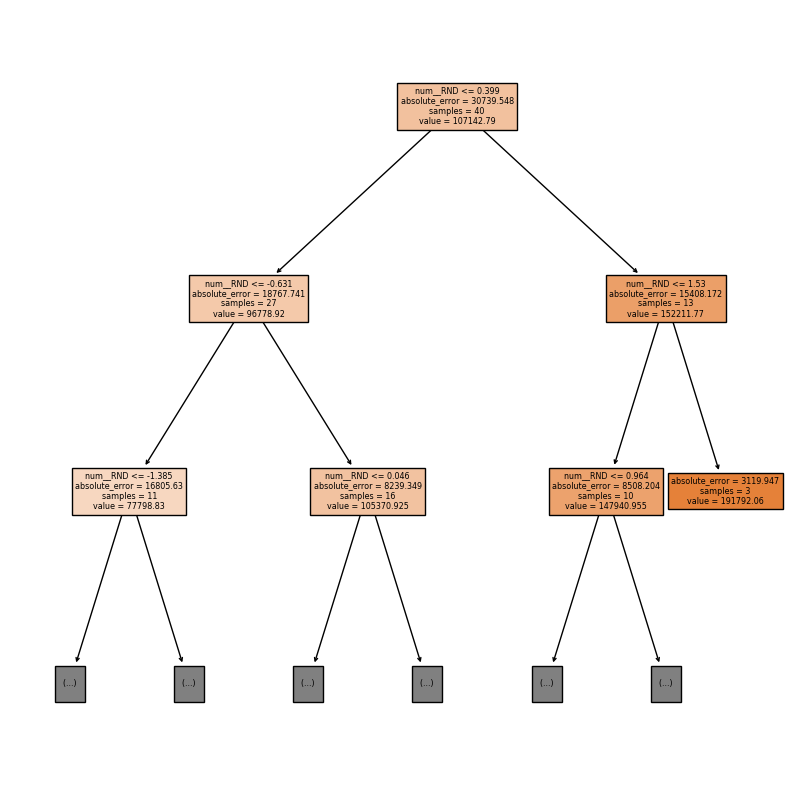

In [47]:
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10))
plot_tree(best_dtr,
          max_depth=2, 
          feature_names=xtrain.columns,
          filled=True)
plt.show()